# Load `python` libraries for some EDA and wrangling

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [40]:
df_cl_mg = pd.read_csv("cleaned_merged_datasets.csv")


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Check how _area_ and _price_ are distributed

In [41]:
# Distribution of area for 'Rent'
percl_area_Rent = df_cl_mg[(df_cl_mg["purpose"] == "Rent")]["area"].describe(percentiles=[.01, .02, .3, .6, .9, 0.95, .99])
# percl_area_Rent

# Distribution of area for 'Sale'
percl_area_Sale = df_cl_mg[(df_cl_mg["purpose"] == "Sale")]["area"].describe(percentiles=[.01, .02, .3, .6, .9, 0.95, .99])
# percl_area_Sale

# Distribution of prices for 'Rent'
percl_price_Rent = df_cl_mg[(df_cl_mg["purpose"] == "Rent")]["price"].describe(percentiles=[.01, .02, .3, .6, .9, 0.95, .99])
# percl_price_Rent

# Distribution of prices for 'Sale'
percl_price_Sale = df_cl_mg[(df_cl_mg["purpose"] == "Sale")]["price"].describe(percentiles=[.01, .02, .3, .6, .9, 0.95, .99])
# percl_price_Sale

In [42]:
print(percl_area_Rent, '\n\n', percl_area_Sale)

count    2.072300e+04
mean     4.241257e+03
std      1.555526e+05
min      0.000000e+00
1%       0.000000e+00
2%       0.000000e+00
30%      1.000000e+03
50%      1.400000e+03
60%      1.650000e+03
90%      3.373000e+03
95%      5.000000e+03
99%      1.200000e+04
max      1.450147e+07
Name: area, dtype: float64 

 count     12978.000000
mean       1664.862321
std        3755.222407
min           1.000000
1%          115.000000
2%          135.000000
30%        1150.000000
50%        1320.000000
60%        1445.000000
90%        2289.300000
95%        3600.000000
99%        7218.216000
max      296600.000000
Name: area, dtype: float64


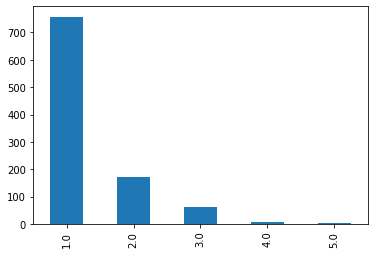

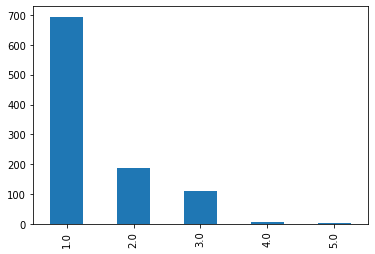

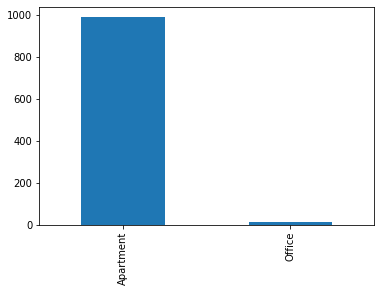

In [44]:
feature1 = 'num_bath_rooms'
feature2 = 'num_bed_rooms'
feature3 = 'building_type'

df_cl_mg[df_cl_mg.area == 0][feature1].value_counts().plot(kind = 'bar')
plt.show()

df_cl_mg[df_cl_mg.area == 0][feature2].value_counts().plot(kind = 'bar')
plt.show()

df_cl_mg[df_cl_mg.area == 0][feature3].value_counts().plot(kind = 'bar')
plt.show()

In [125]:
print(percl_price_Rent, '\n\n', percl_price_Sale)

count    2.072300e+04
mean     1.048616e+07
std      8.390854e+08
min      0.000000e+00
2%       0.000000e+00
30%      2.000000e+04
50%      3.300000e+04
60%      5.000000e+04
90%      3.800000e+05
95%      7.350000e+05
99%      2.500000e+06
max      1.000000e+11
Name: price, dtype: float64 

 count    1.297800e+04
mean     2.762862e+09
std      2.124047e+11
min      0.000000e+00
2%       2.263500e+06
30%      5.500000e+06
50%      7.350000e+06
60%      8.350000e+06
90%      2.100000e+07
95%      3.800000e+07
99%      5.423000e+09
max      2.400000e+13
Name: price, dtype: float64


In [45]:
df_cl_mg.shape

(33701, 24)

## Create a "clean" dataset for _Sale_
    . Subset to "Sale"
    . Only "Apartments"
    . Get rid of area and price outliers

In [46]:
df_sale = df_cl_mg[(df_cl_mg.purpose == 'Sale')  &
                   (df_cl_mg.building_type == 'Apartment')  &
                   (df_cl_mg.area > percl_area_Sale['1%']) & 
                   (df_cl_mg.area <= percl_area_Sale['99%']) & 
                  (df_cl_mg.price <= percl_price_Sale['95%']) &
                   (df_cl_mg.price > percl_price_Sale['2%'])
                  ][['price', 'area', 'num_bath_rooms', 'num_bed_rooms', 'zone']]

In [178]:
# df_sale['price'].describe(percentiles=[0.02, .3, .6, .9, 0.95, .99])

In [47]:
df_sale.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
price,10740.0,NaN,NaN,NaN,8791256.480066,5330544.604312,2275000.0,5250000.0,7200000.0,10500000.0,38000000.0
area,10740.0,NaN,NaN,NaN,1362.240782,437.435757,250.0,1100.0,1300.0,1550.0,6357.0
num_bath_rooms,10740.0,NaN,NaN,NaN,1.621415,1.516912,0.0,0.0,2.0,3.0,8.0
num_bed_rooms,10740.0,NaN,NaN,NaN,2.924022,0.5266,0.0,3.0,3.0,3.0,7.0
zone,10714,53,Mirpur,3671,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data imputation & transformation

#### How many properties don't have `num_bath_rooms` info?
An apartment not having any bathrooms is very unlikely ==> these are just missing values (an error at some point in the process)

In [48]:
df_sale[df_sale.num_bath_rooms==0].shape

(4662, 5)

There are too many entries with missing `num_bath_rooms` info ( == 0) which is going to have a negative influence on estimating parameters.

Let's impute these "missing values" with the mean.

In [49]:
mean_num_bath_rooms = df_sale[df_sale.num_bath_rooms!=0].num_bath_rooms.mean()
# mean_num_bath_rooms
df_sale['num_bath_rooms'] = np.where(df_sale.num_bath_rooms==0, mean_num_bath_rooms, df_sale.num_bath_rooms)

In [51]:
# Sanity check
df_sale[df_sale.num_bath_rooms==0].shape

(0, 5)

In [52]:
df_sale.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
price,10740.0,NaN,NaN,NaN,8791256.480066,5330544.604312,2275000.0,5250000.0,7200000.0,10500000.0,38000000.0
area,10740.0,NaN,NaN,NaN,1362.240782,437.435757,250.0,1100.0,1300.0,1550.0,6357.0
num_bath_rooms,10740.0,NaN,NaN,NaN,2.865087,0.533222,1.0,2.865087,2.865087,3.0,8.0
num_bed_rooms,10740.0,NaN,NaN,NaN,2.924022,0.5266,0.0,3.0,3.0,3.0,7.0
zone,10714,53,Mirpur,3671,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### As we saw in the EDA: the price increases non-linearly (_exponetially_) with `area` and `num_bath/bed_rooms`
==> Log transform price so that we can fit a linear model

In [55]:
df_sale['price_log'] = np.log(df_sale['price'])

In [56]:
df_sale.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
price,10740.0,NaN,NaN,NaN,8791256.480066,5330544.604312,2275000.0,5250000.0,7200000.0,10500000.0,38000000.0
area,10740.0,NaN,NaN,NaN,1362.240782,437.435757,250.0,1100.0,1300.0,1550.0,6357.0
num_bath_rooms,10740.0,NaN,NaN,NaN,2.865087,0.533222,1.0,2.865087,2.865087,3.0,8.0
num_bed_rooms,10740.0,NaN,NaN,NaN,2.924022,0.5266,0.0,3.0,3.0,3.0,7.0
zone,10714,53,Mirpur,3671,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price_log,10740.0,NaN,NaN,NaN,15.843863,0.52274,14.637491,15.473739,15.789592,16.166886,17.453097


In [57]:
df_sale[df_sale.num_bed_rooms == 0].shape

(6, 6)

In [59]:
df_sale.to_csv('df-sale.csv', index=False)

<br>


# Load `R` for linear mixed-effects models

In [64]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [72]:
%%R

# Start fresh
rm(list = ls())
ls()

character(0)


In [73]:
%%R

# Load the packages
library(Matrix)
library(lme4)

In [74]:
%%R
df.sale = read.csv("df-sale.csv")
ls()

[1] "df.sale"


In [75]:
%%R
head(df.sale)

  X    price area num_bath_rooms num_bed_rooms            zone price_log
1 0  6100000 1185       2.865087             3        Khilgaon  15.62380
2 1 28900000 2464       4.000000             3       Dhanmondi  17.17935
3 2  7500000 1140       2.865087             3          Mirpur  15.83041
4 3 20000000 1920       3.000000             3 Bashundhara R/A  16.81124
5 4 10800000 1445       3.000000             3        Khilgaon  16.19506
6 5  5000000  925       2.865087             2        Khilgaon  15.42495


In [76]:
%%R
dim(df.sale)

[1] 10740     7


In [78]:
%%R

# Make 'zone' as factor for using it as a random effect
df.sale$zone = as.factor(df.sale$zone)

### Fit an `lmer` model

In [79]:
%%R
lmer.sale.allZones = lmer(price_log ~ 
                          area + 
                          num_bath_rooms + 
                          num_bed_rooms + 
                          (1 | zone), 
                          data = df.sale)


In [80]:
%%R
summary(lmer.sale.allZones)

Linear mixed model fit by REML ['lmerMod']
Formula: price_log ~ area + num_bath_rooms + num_bed_rooms + (1 | zone)
   Data: df.sale

REML criterion at convergence: -92.9

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-13.1753  -0.5881   0.0093   0.5783   5.5183 

Random effects:
 Groups   Name        Variance Std.Dev.
 zone     (Intercept) 0.09608  0.3100  
 Residual             0.05673  0.2382  
Number of obs: 10740, groups:  zone, 54

Fixed effects:
                Estimate Std. Error t value
(Intercept)    1.440e+01  4.709e-02 305.740
area           8.449e-04  8.265e-06 102.222
num_bath_rooms 5.196e-02  5.241e-03   9.915
num_bed_rooms  9.507e-03  6.227e-03   1.527

Correlation of Fixed Effects:
            (Intr) area   nm_bt_
area         0.059              
num_bth_rms -0.165 -0.248       
num_bed_rms -0.171 -0.576 -0.234


### Save the model for generating predictions

In [81]:
%%R

saveRDS(lmer.sale.allZones, file = "lmer.sale.allZones.rds")

## Create a "clean" dataset for _Rent_
    . Subset to "Rent"
    . Only "Apartments"
    . Get rid of area and price outliers
        - Around 1000 'Rent' 'Apartments' have area == 0

In [ ]:
# # Distribution of area for 'Rent'
# percl_area_Rent = df_cl_mg[(df_cl_mg["purpose"] == "Rent")]["area"].describe(percentiles=[.01, .02, .3, .6, .9, 0.95, .99])
# # percl_area_Rent

# # Distribution of prices for 'Rent'
# percl_price_Rent = df_cl_mg[(df_cl_mg["purpose"] == "Rent")]["price"].describe(percentiles=[.01, .02, .3, .6, .9, 0.95, .99])
# # percl_price_Rent


In [82]:
percl_area_Rent

count    2.072300e+04
mean     4.241257e+03
std      1.555526e+05
min      0.000000e+00
1%       0.000000e+00
2%       0.000000e+00
30%      1.000000e+03
50%      1.400000e+03
60%      1.650000e+03
90%      3.373000e+03
95%      5.000000e+03
99%      1.200000e+04
max      1.450147e+07
Name: area, dtype: float64

In [92]:
percl_price_Rent

count    2.072300e+04
mean     1.048616e+07
std      8.390854e+08
min      0.000000e+00
1%       0.000000e+00
2%       0.000000e+00
30%      2.000000e+04
50%      3.300000e+04
60%      5.000000e+04
90%      3.800000e+05
95%      7.350000e+05
99%      2.500000e+06
max      1.000000e+11
Name: price, dtype: float64

In [97]:
df_cl_mg[(df_cl_mg["purpose"] == "Rent") & (df_cl_mg['area'] == 0)].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1001 entries, 17451 to 33685
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   area                                   1001 non-null   float64
 1   building_type                          1001 non-null   object 
 2   building_nature                        1001 non-null   object 
 3   image_url                              0 non-null      object 
 4   num_bath_rooms                         1001 non-null   float64
 5   num_bed_rooms                          1001 non-null   float64
 6   price                                  1001 non-null   float64
 7   property_description                   1001 non-null   object 
 8   property_overview                      922 non-null    object 
 9   property_url                           1001 non-null   object 
 10  purpose                                1001 non-null   object 
 11 

In [96]:
df_cl_mg[(df_cl_mg["purpose"] == "Rent") & (df_cl_mg['price'] == 0)].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 477 entries, 17603 to 33654
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   area                                   477 non-null    float64
 1   building_type                          477 non-null    object 
 2   building_nature                        477 non-null    object 
 3   image_url                              0 non-null      object 
 4   num_bath_rooms                         477 non-null    float64
 5   num_bed_rooms                          477 non-null    float64
 6   price                                  477 non-null    float64
 7   property_description                   477 non-null    object 
 8   property_overview                      445 non-null    object 
 9   property_url                           477 non-null    object 
 10  purpose                                477 non-null    object 
 11  

In [172]:



df_rent = df_cl_mg[(df_cl_mg.purpose == 'Rent')  &
                   (df_cl_mg.building_type == 'Apartment')  &
                   (df_cl_mg.area > 0) & # many properties (n = 1001) have area == 0 -> get rid of them
                   (df_cl_mg.area <= percl_area_Rent['99%']) & 
                  (df_cl_mg.price <= percl_price_Rent['99%']) &
                   (df_cl_mg.price > 0) # Some properties (n = 477) don't have price info -> get rid of them
                  ][['price', 'area', 'num_bath_rooms', 'num_bed_rooms', 'zone']]

In [173]:
df_rent.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
price,14619.0,NaN,NaN,NaN,63654.494151,179817.65392,1.0,16000.0,25000.0,50000.0,2500000.0
area,14619.0,NaN,NaN,NaN,1527.354333,864.444689,1.0,950.0,1300.0,2000.0,12000.0
num_bath_rooms,14619.0,NaN,NaN,NaN,2.379233,1.411636,0.0,2.0,3.0,3.0,31.0
num_bed_rooms,14619.0,NaN,NaN,NaN,2.762296,0.86782,0.0,2.0,3.0,3.0,10.0
zone,14571,60,Mirpur,2050,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data imputation & transformation

#### How many properties don't have `num_bath_rooms` info?
An apartment not having any bathrooms is very unlikely ==> these are just missing values (an error at some point in the process)

In [174]:
df_rent[df_rent.num_bath_rooms==0].shape

(2284, 5)

There are too many entries with missing `num_bath_rooms` info ( == 0) which is going to have a negative influence on estimating parameters.

Let's impute these "missing values" with the mean.

In [175]:
mean_num_bath_rooms_rent = df_rent[df_rent.num_bath_rooms!=0].num_bath_rooms.mean()
# mean_num_bath_rooms
df_rent['num_bath_rooms'] = np.where(df_rent.num_bath_rooms==0, mean_num_bath_rooms_rent, df_rent.num_bath_rooms)

In [176]:
# Sanity check
df_rent[df_rent.num_bath_rooms==0].shape

(0, 5)

In [177]:
df_rent.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
price,14619.0,NaN,NaN,NaN,63654.494151,179817.65392,1.0,16000.0,25000.0,50000.0,2500000.0
area,14619.0,NaN,NaN,NaN,1527.354333,864.444689,1.0,950.0,1300.0,2000.0,12000.0
num_bath_rooms,14619.0,NaN,NaN,NaN,2.819781,0.971842,1.0,2.0,3.0,3.0,31.0
num_bed_rooms,14619.0,NaN,NaN,NaN,2.762296,0.86782,0.0,2.0,3.0,3.0,10.0
zone,14571,60,Mirpur,2050,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**It's fine to have num_bed_rooms to be zero (they could be studio apartments) as long as the number is not too high**

In [178]:
df_rent[df_rent.num_bed_rooms==0].shape

(288, 5)

#### As we saw in the EDA: the price increases non-linearly (_exponetially_) with `area` and `num_bath/bed_rooms`
==> Log transform price so that we can fit a linear model

In [179]:
df_rent['price_log'] = np.log(df_rent['price'])

In [180]:
df_rent.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
price,14619.0,NaN,NaN,NaN,63654.494151,179817.65392,1.0,16000.0,25000.0,50000.0,2500000.0
area,14619.0,NaN,NaN,NaN,1527.354333,864.444689,1.0,950.0,1300.0,2000.0,12000.0
num_bath_rooms,14619.0,NaN,NaN,NaN,2.819781,0.971842,1.0,2.0,3.0,3.0,31.0
num_bed_rooms,14619.0,NaN,NaN,NaN,2.762296,0.86782,0.0,2.0,3.0,3.0,10.0
zone,14571,60,Mirpur,2050,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price_log,14619.0,NaN,NaN,NaN,10.302186,1.041855,0.0,9.680344,10.126631,10.819778,14.731801


**How properties are distributed across different price values?**

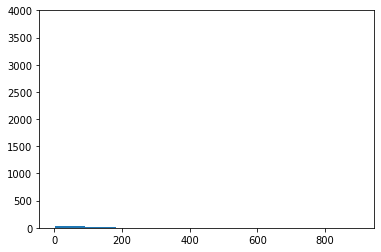

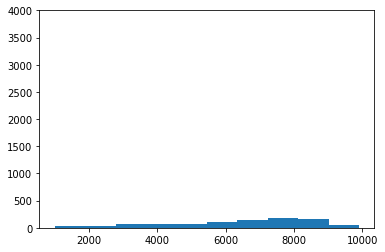

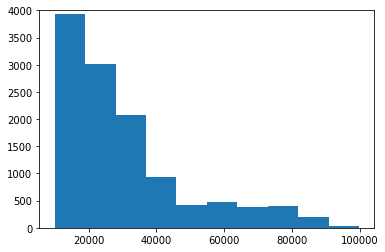

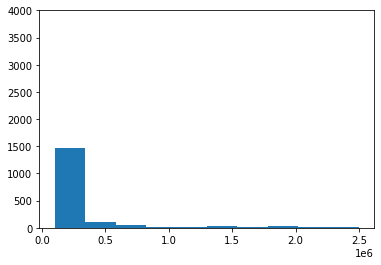

In [182]:
# df_rent['price'].plot(kind = 'hist')

plt.hist(df_rent[df_rent.price < 1000]['price'])
plt.ylim(0,4000)
plt.show()

plt.hist(df_rent[(df_rent.price >= 1000) & (df_rent.price < 10000)]['price'])
plt.ylim(0,4000)
plt.show()

plt.hist(df_rent[(df_rent.price >= 10000) & (df_rent.price < 100000)]['price'])
plt.ylim(0,4000)
plt.show()

# plt.hist(df_rent[(df_rent.price >= 100000) & (df_rent.price < 1000000)]['price'])
# plt.ylim(0,4000)
# plt.show()

plt.hist(df_rent[df_rent.price >= 100000]['price'])
plt.ylim(0,4000)
plt.show()

In [168]:
import seaborn as sns

In [203]:
# g = sns.relplot(y="price_log", x="area", 
#                 data = df_rent,
#                 kind="scatter",
#                 height=5, aspect=2
#                )
# g.set_titles('{row_name}', fontsize=24)
# g.set_axis_labels('Area (Sq. ft.)', 'Price (log-transformed)')

# plt.show()

In [205]:
# g = sns.relplot(y="price_log", x="area", 
#                 data = df_sale,
#                 kind="scatter",
#                 height=5, aspect=2
#                )
# g.set_axis_labels('Area (Sq. ft.)', 'Price (log-transformed)')
# g.fig.suptitle('Price vs. area for each property type', fontsize=12, y=1.02)

# plt.show()

In [144]:
df_rent.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14708 entries, 10859 to 33681
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   price           14708 non-null  float64
 1   area            14708 non-null  float64
 2   num_bath_rooms  14708 non-null  float64
 3   num_bed_rooms   14708 non-null  float64
 4   zone            14658 non-null  object 
 5   price_log       14708 non-null  float64
dtypes: float64(5), object(1)
memory usage: 804.3+ KB


In [185]:
df_rent.to_csv('df-rent.csv', index=False)

<br>


# Load `R` for linear mixed-effects models

In [146]:
# %load_ext rpy2.ipython

In [187]:
%%R

# Start fresh
rm(list = ls())
ls()

character(0)


In [188]:
%%R

# Load the packages
library(Matrix)
library(lme4)

In [189]:
%%R
df.rent = read.csv("df-rent.csv")
ls()

[1] "df.rent"


In [190]:
%%R
summary(df.rent)

     price              area       num_bath_rooms  num_bed_rooms   
 Min.   :      1   Min.   :    1   Min.   : 1.00   Min.   : 0.000  
 1st Qu.:  16000   1st Qu.:  950   1st Qu.: 2.00   1st Qu.: 2.000  
 Median :  25000   Median : 1300   Median : 3.00   Median : 3.000  
 Mean   :  63654   Mean   : 1527   Mean   : 2.82   Mean   : 2.762  
 3rd Qu.:  50000   3rd Qu.: 2000   3rd Qu.: 3.00   3rd Qu.: 3.000  
 Max.   :2500000   Max.   :12000   Max.   :31.00   Max.   :10.000  
     zone             price_log    
 Length:14619       Min.   : 0.00  
 Class :character   1st Qu.: 9.68  
 Mode  :character   Median :10.13  
                    Mean   :10.30  
                    3rd Qu.:10.82  
                    Max.   :14.73  


In [191]:
%%R
dim(df.rent)

[1] 14619     6


In [192]:
%%R

# Make 'zone' as factor for using it as a random effect
df.rent$zone = as.factor(df.rent$zone)

### Fit an `lmer` model

In [193]:
%%R
lmer.rent.allZones = lmer(price_log ~ 
                          area + 
                          num_bath_rooms + 
                          num_bed_rooms + 
                          (1 | zone), 
                          data = df.rent)


In [194]:
%%R
summary(lmer.rent.allZones)

Linear mixed model fit by REML ['lmerMod']
Formula: price_log ~ area + num_bath_rooms + num_bed_rooms + (1 | zone)
   Data: df.rent

REML criterion at convergence: 32072.2

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-15.3209  -0.3237  -0.0781   0.1978   7.0039 

Random effects:
 Groups   Name        Variance Std.Dev.
 zone     (Intercept) 0.4169   0.6457  
 Residual             0.5168   0.7189  
Number of obs: 14619, groups:  zone, 61

Fixed effects:
                Estimate Std. Error t value
(Intercept)    9.005e+00  9.304e-02  96.787
area           4.905e-04  1.001e-05  49.018
num_bath_rooms 5.177e-02  8.731e-03   5.930
num_bed_rooms  3.082e-02  9.023e-03   3.415

Correlation of Fixed Effects:
            (Intr) area   nm_bt_
area         0.001              
num_bth_rms -0.067 -0.354       
num_bed_rms -0.123 -0.216 -0.429


### Save the model for generating predictions

In [198]:
%%R

saveRDS(lmer.rent.allZones, file = "lmer.rent.allZones.rds")